In [1]:
import pandas as
from rdkit import Chem
from rdkit.Chem import PandasTools

# Path to your SDF file
sdf_file = 'data/combined_mols_0_to_1000000.sdf'

# Load the SDF file as a supplier object
suppl = Chem.SDMolSupplier(sdf_file)

# Loop through the supplier object and work with molecules
for mol in suppl:
    if mol is not None:  # Check if the molecule is successfully loaded
        print(Chem.MolToSmiles(mol)) 
        break

Failed to import pandas formats module
Failed to patch pandas - PandasTools will have limited functionality


O=C(O)/C=C/c1cnc2c(c1)CCC(O)=N2


In [19]:
from rdkit import Chem
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*')   

# Path to your SDF file
sdf_file = 'data/combined_mols_0_to_1000000.sdf'

# Create an SDMolSupplier object to read the SDF file
supplier = Chem.SDMolSupplier(sdf_file)

def is_valid_molecule(mol):
    """Check if all hydrogen atoms have exactly one bond."""
    total = 0
    for atom in mol.GetAtoms():
        if atom.GetSymbol() == 'H':
            total += 1
            if atom.GetDegree() != 1:
                return False
        if atom.GetSymbol() != 'H' and atom.GetDegree() == 1:
            return False
    return total > 1

molecule_list = []

# Iterate through each molecule in the SDF file
total_printed = 0
for index, mol in enumerate(supplier):
    if index % 100000 == 0:
        print(f'{index} / {len(supplier)}')
    
    if mol is not None and is_valid_molecule(mol):  # Check if the molecule is successfully read
        hydrogen_atoms_info = []
        other_atoms_info = []
        
        conf = mol.GetConformer()
        for atom in mol.GetAtoms():
            pos = conf.GetAtomPosition(atom.GetIdx())  # Get current atom position
            if atom.GetSymbol() == 'H':
                # For hydrogen atoms, find the atoms they are connected to
                for neighbor in atom.GetNeighbors():
                    neighbor_pos = conf.GetAtomPosition(neighbor.GetIdx())
                    hydrogen_atoms_info.append({
                        "H_position": (pos.x, pos.y, pos.z),
                        "connected_atom_type": neighbor.GetSymbol(),
                        "connected_atom_position": (neighbor_pos.x, neighbor_pos.y, neighbor_pos.z)
                    })
            else:
                # For other atoms, simply record their position
                other_atoms_info.append({
                    "atom_type": atom.GetSymbol(),
                    "position": (pos.x, pos.y, pos.z)
                })
                
        molecule_list.append({
            'H': hydrogen_atoms_info,
            'Other': other_atoms_info
        })
        
        print(hydrogen_atoms_info)


0 / 1000000
100000 / 1000000
[{'H_position': (2.4848, 1.9546, -0.1699), 'connected_atom_type': 'N', 'connected_atom_position': (3.1422, 1.1633, -0.1779)}, {'H_position': (6.0285, -2.1335, -1.8783), 'connected_atom_type': 'N', 'connected_atom_position': (5.7881, -2.898, -1.2329)}]
200000 / 1000000
[{'H_position': (3.3488, 3.1978, -1.6072), 'connected_atom_type': 'N', 'connected_atom_position': (2.6032, 3.6429, -1.0689)}, {'H_position': (-2.2282, 4.3897, 1.861), 'connected_atom_type': 'N', 'connected_atom_position': (-1.4752, 3.933, 1.3427)}]
300000 / 1000000
[{'H_position': (-0.1023, -0.3474, -0.3552), 'connected_atom_type': 'C', 'connected_atom_position': (0.8429, -0.0252, 0.0659)}, {'H_position': (3.2812, -0.8964, -1.0761), 'connected_atom_type': 'Si', 'connected_atom_position': (2.5468, -0.087, -0.015)}]
[{'H_position': (2.7244, 0.3878, -2.0758), 'connected_atom_type': 'N', 'connected_atom_position': (3.4981, 0.367, -1.4107)}, {'H_position': (4.9185, -3.3791, 0.7986), 'connected_atom

In [33]:
import numpy as np
import numpy.linalg as la

def molecule_to_np(hydrogen_list):
    n = len(hydrogen_list)
    
    h_q = np.zeros((3, n))
    h_p = np.zeros((3, n))
    n_q = np.zeros((3, n))
    h_l = np.zeros(n)
    h_m = np.zeros(n)
    
    for i, atom in enumerate(hydrogen_list):
        h_q[:, i] = np.array(atom['H_position'])
        n_q[:, i] = np.array(atom['connected_atom_position'])
        h_l[i] = np.linalg.norm(h_q[:, i] - n_q[:, i])
        h_m[i] = 1
        
        
    print(h_q, '\n', h_p, '\n', n_q)
    return h_q, h_p, n_q, h_l, h_m

h_q, h_p, n_q, h_l, h_m = molecule_to_np(molecule_list[10]['H'])

[[ 0.6726  4.8793]
 [ 0.2915 -0.5961]
 [-1.8353 -0.1572]] 
 [[0. 0.]
 [0. 0.]
 [0. 0.]] 
 [[ 0.2148  4.5022]
 [ 0.2589 -0.4224]
 [-0.9206 -1.0968]]


In [34]:
# Constants
k_spr = 0.1
eps = 1
sigma = 0.1

def kinetic_energy(h_p, h_m):
    # Calculate the squared 2-norm of each momentum vector, then sum with mass consideration
    ke = np.sum(np.sum(h_p**2, axis=0) / (2 * h_m))  # axis=0 sums across rows for each column vector
    return ke

def potential_energy(h_q, n_q, h_l, f_c, f_i):
    energy = 0
    k = h_q.shape[1]  # Number of particles
    for i in range(k):
        for j in range(i + 1, k):
            r_ij = np.linalg.norm(h_q[:, i] - h_q[:, j])
            energy += f_c(r_ij)
        r_i = np.linalg.norm(h_q[:, i] - n_q[:, i])
        l = h_l[i]
        energy += f_i(r_i, l)
    return energy

def v_t(q, t, e_t):
    # Assuming e(t) is a scalar or a vector function that properly broadcasts over q's dimensions
    return np.sum(e_t(t) * q)

# def f_c(x):
#     return 1/x # Straightforward to differentiate

# def df_c(x):
#     return -1/x**2

def f_i(x, l):
    return k_spr*(x - l)**2

def df_i(x, l):
    return k_spr*2*(x - l)

def f_c(x):
    return 4*eps*((sigma/x)**12 - (sigma/x)**6) # Straightforward to differentiate

def df_c(x):
    return -4*eps*(12*sigma**12/x**11 - 6*sigma**6/x**5)

def e(t):
    return 0 # Consider conservative system initially

def H(h_p, h_q, n_q, h_m, h_l, f_c, f_i, e_t, t):
    return kinetic_energy(h_p, h_m) + potential_energy(h_q, n_q, h_l, f_c, f_i) + v_t(h_q, t, e_t)

def dH_dp_i(h_p, h_m, i):
    return h_p[:, i] / h_m[i]

def dH_dq_i(h_q, h_m, n_q, h_l, i):
    d, k = h_q.shape
    total = np.zeros(d)
    for j in range(k):
        if i == j:
            continue
        x = h_q[:, i] - h_q[:, j]
        norm_x = la.norm(x)
        total += x/norm_x * df_c(norm_x)
    x = h_q[:, i] - n_q[:, i]
    norm_x = la.norm(x)
    total += x / norm_x * df_i(norm_x, h_l[i])
    return total

def dH_dp(h_p, h_m):
    d, k = h_p.shape
    diff_p = np.zeros_like(h_p)
    for i in range(k):
        diff_p[:, i] = dH_dp_i(h_p, h_m, i)
    return diff_p

def dH_dq(h_q, h_m, n_q, h_l):
    d, k = h_q.shape
    diff_q = np.zeros_like(h_q)
    for i in range(k):
        diff_q[:, i] = dH_dq_i(h_q, h_m, n_q, h_l, i)
    return diff_q
    
    

In [50]:

def leapfrog_integration(q0, p0, n_q, h_l, m, dt, total_time):
    """
    Perform leapfrog integration.
    """
    steps = int(total_time / dt)
    q, p = q0.copy(), p0.copy()
    
    # Initialize arrays to store trajectories for plotting
    trajectories = np.zeros((q.shape[0], q.shape[1], steps + 1))
    trajectories[:, :, 0] = q
    
    momentums = np.zeros((p.shape[0], p.shape[1], steps + 1))
    momentums[:, :, 0] = p
    
    for step in range(steps):
        p_half = p - 0.5 * dt * dH_dq(q, m, n_q, h_l)
        q = q + dt * dH_dp(p_half, m)
        p = p_half - 0.5 * dt * dH_dq(q, m, n_q, h_l)
        
        # Store positions for plotting
        trajectories[:, :, step + 1] = q
        momentums[:, :, step + 1] = p
    
    return trajectories, momentums

In [51]:

dt = 0.001
total_time = 10*np.pi  # One orbital period, simplified

trajectories, momentums = leapfrog_integration(h_q, h_p, n_q, h_l, h_m, dt, total_time)

(3, 2, 31416)


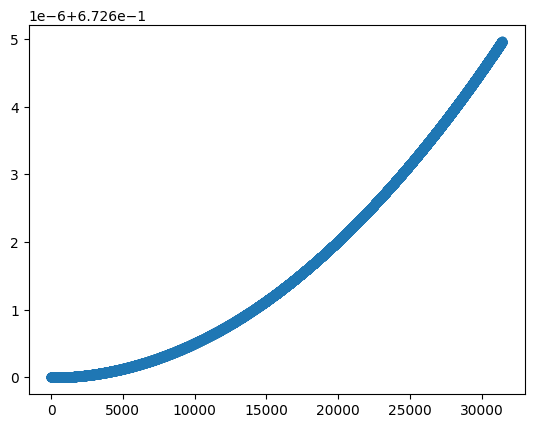

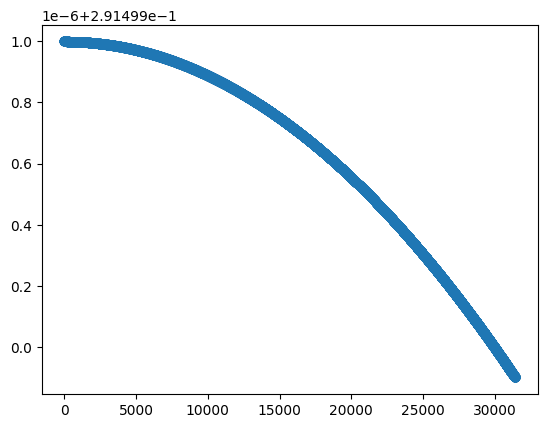

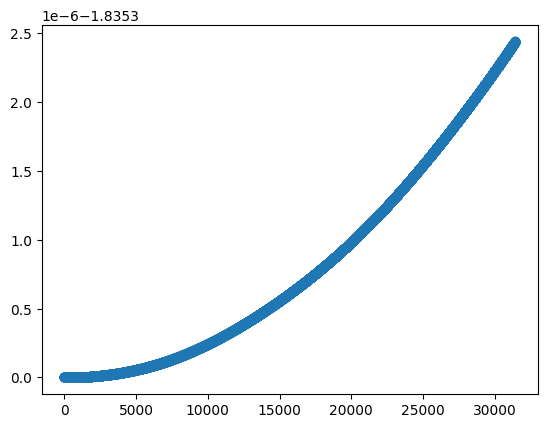

In [54]:
import matplotlib.pyplot as plt
print(trajectories.shape)
plt.scatter(list(range(trajectories.shape[2])), trajectories[0, 0, :])
plt.show()

plt.scatter(list(range(trajectories.shape[2])), trajectories[1, 0, :])
plt.show()

plt.scatter(list(range(trajectories.shape[2])), trajectories[2, 0, :])
plt.show()